# Authors: Jakub Bandurski, Anirban Das

## This notebook performs all necessary computations needed to generate predictions of the final model for the regression task

Data Source: Provided by the Professor in the Class

# 1. Library Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_percentage_error

# 2. Data Preprocessing

## Basic EDA

In [2]:
newborn = pd.read_csv('./../data/newborn_train.csv')
newborn_test = pd.read_csv('./../data/newborn_test.csv')

df = pd.DataFrame(newborn)
df1 = pd.DataFrame(newborn_test)

#Checking the data
print(newborn.describe())
print("___________________________________________________________")
print(newborn.head())
print("___________________________________________________________")
print(newborn.info())
print(df.shape[0])

       mother_body_mass_index  mother_marital_status  mother_delivery_weight  \
count            2.251516e+06           1.985606e+06            2.363158e+06   
mean             2.716721e+01           1.399560e+00            1.883170e+02   
std              6.755758e+00           4.898080e-01            4.136924e+01   
min              1.300000e+01           1.000000e+00            1.000000e+02   
25%              2.230000e+01           1.000000e+00            1.590000e+02   
50%              2.570000e+01           1.000000e+00            1.810000e+02   
75%              3.070000e+01           2.000000e+00            2.100000e+02   
max              6.980000e+01           2.000000e+00            4.000000e+02   

        mother_race  mother_height  mother_weight_gain    father_age  \
count  2.398116e+06   2.153587e+06        2.324643e+06  1.953610e+06   
mean   1.522342e+00   6.412125e+01        2.948373e+01  3.180109e+01   
std    1.111554e+00   2.835525e+00        1.514630e+01  6.81264

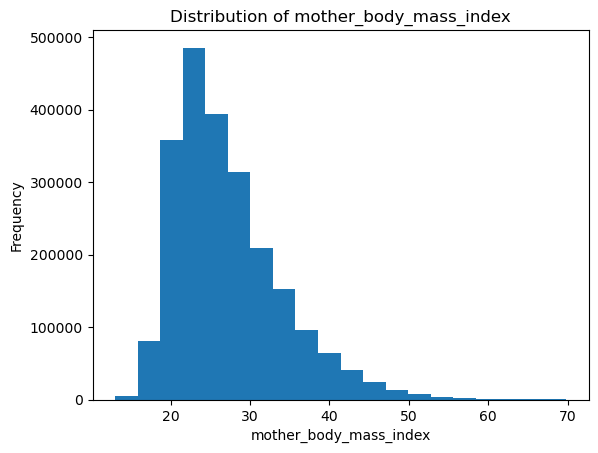

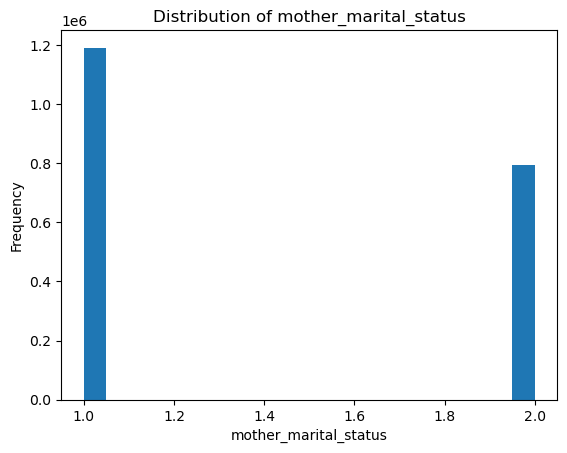

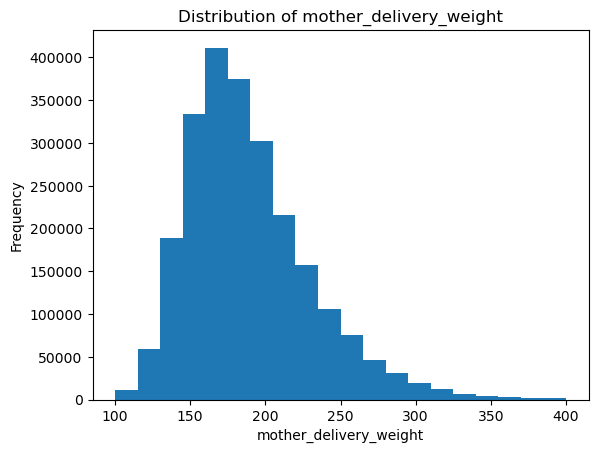

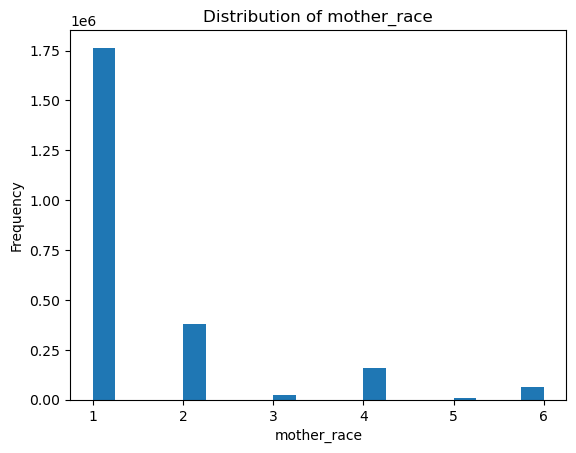

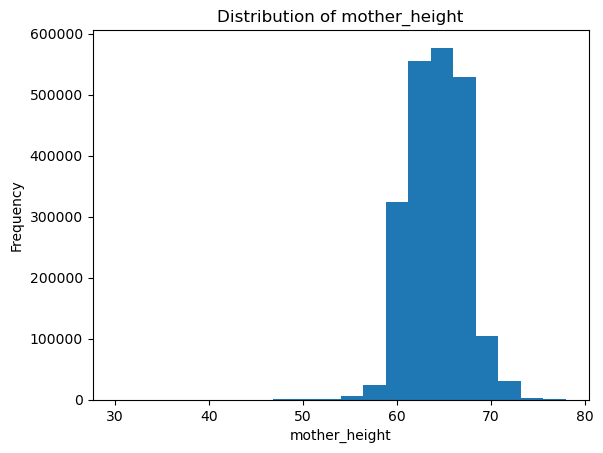

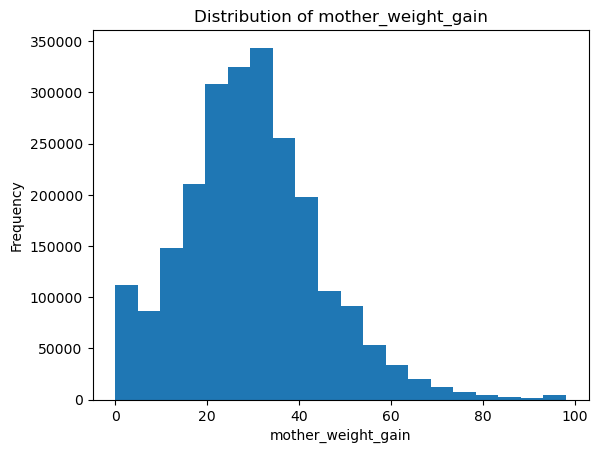

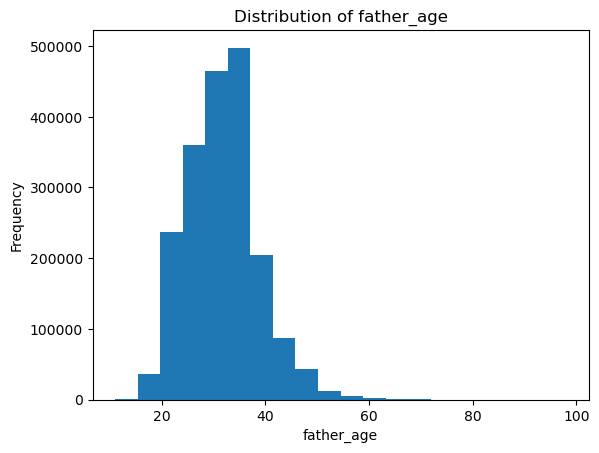

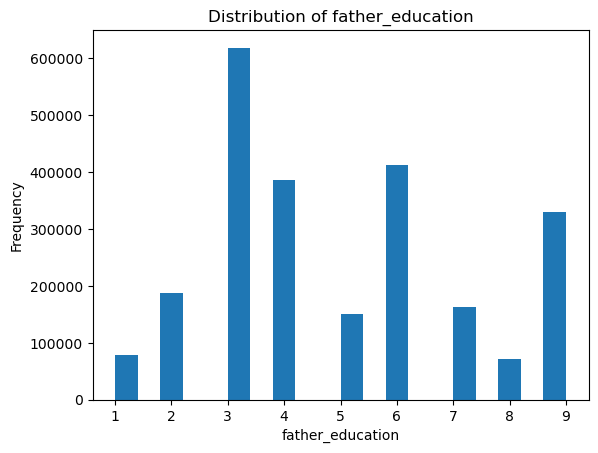

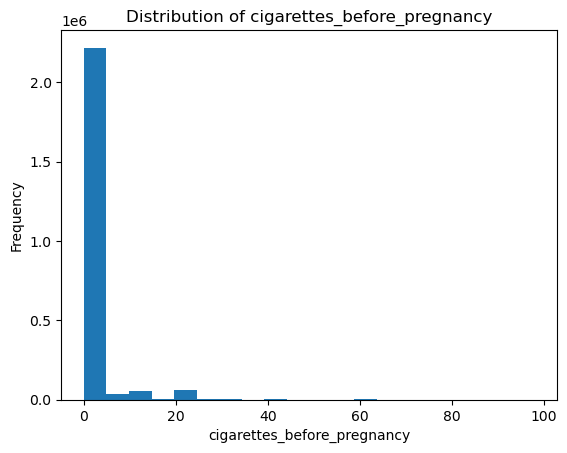

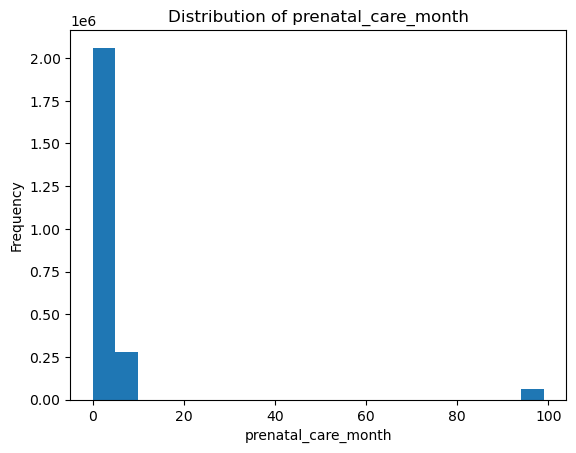

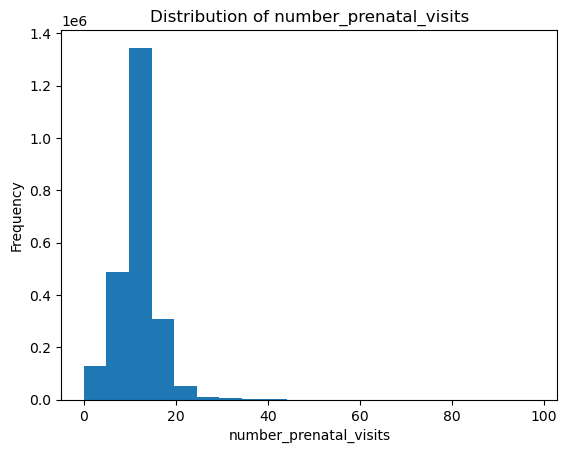

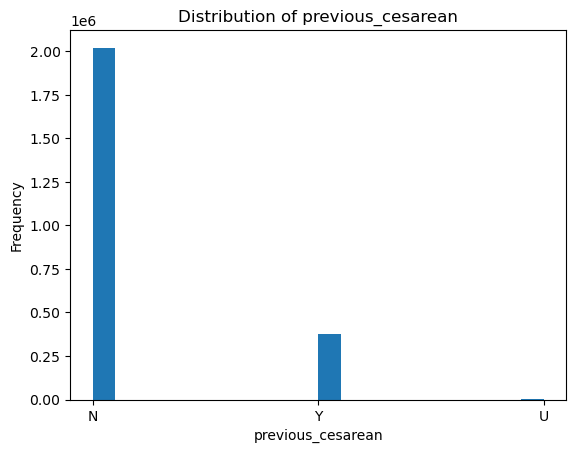

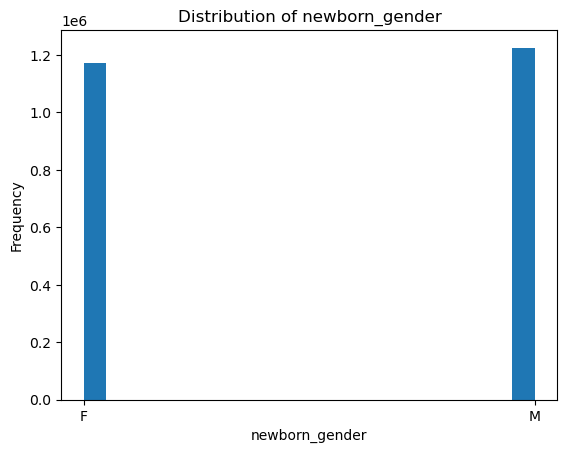

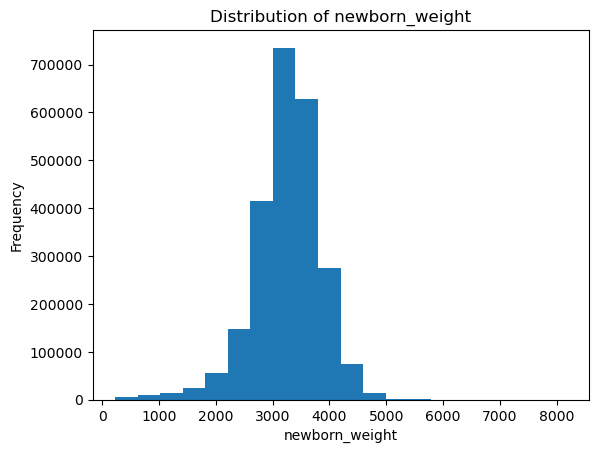

In [3]:
for col in df.columns:
    plt.hist(df[col], bins = 20)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f'Distribution of {col}')
    plt.show()

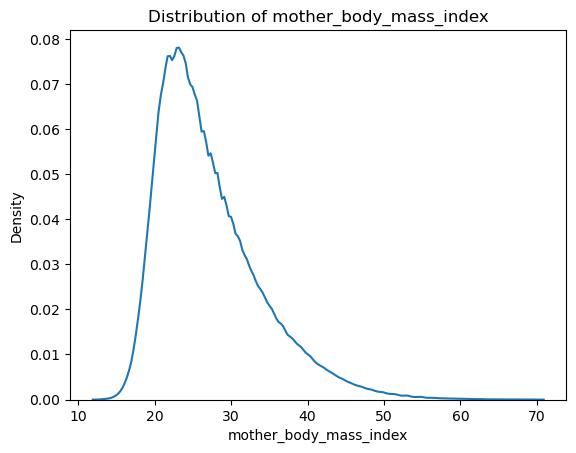

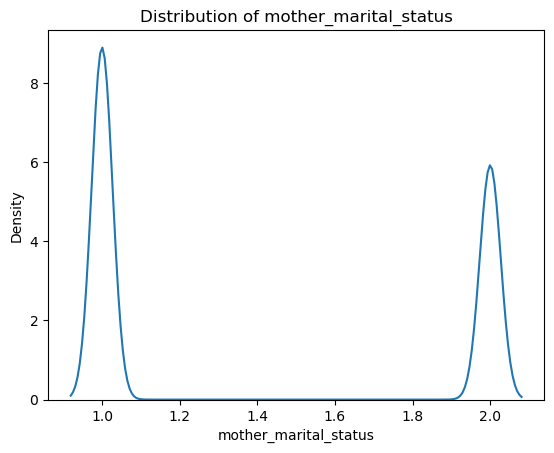

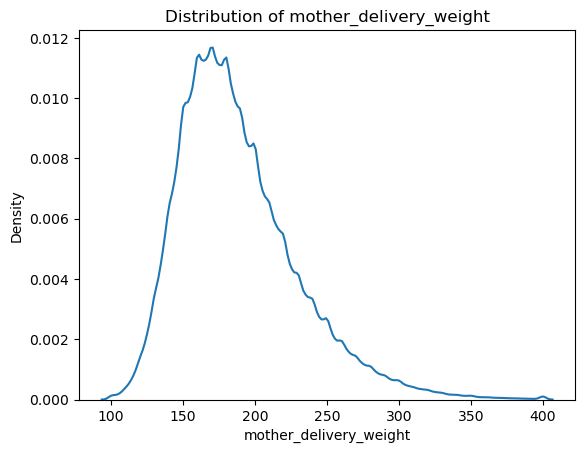

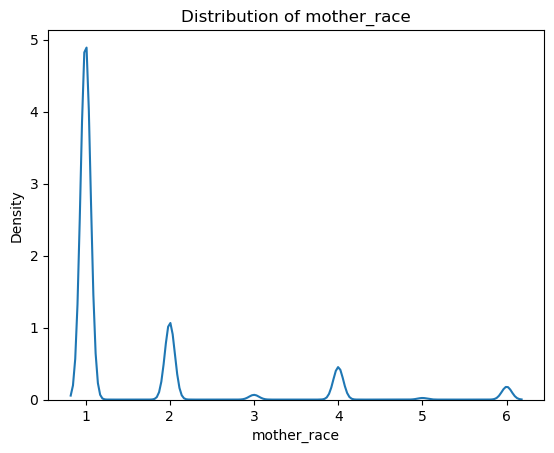

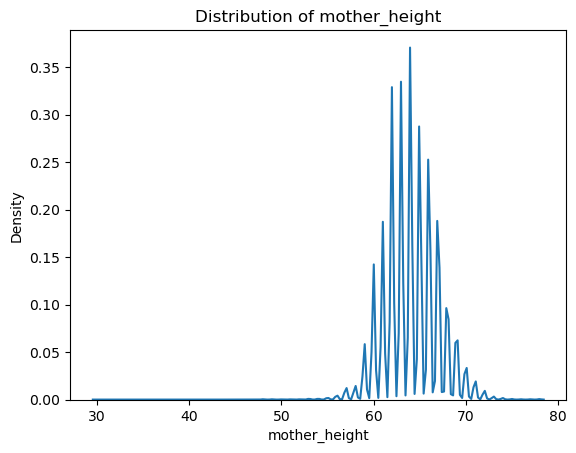

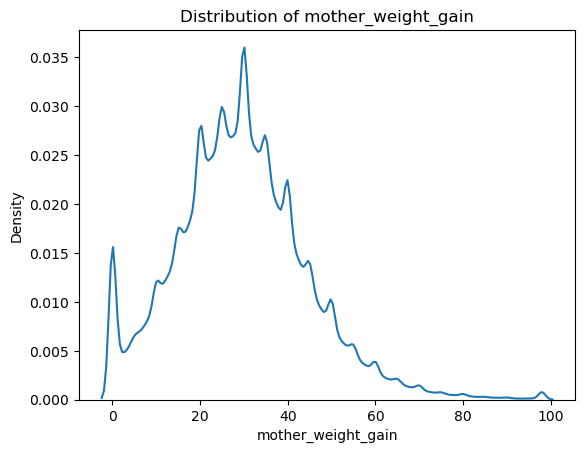

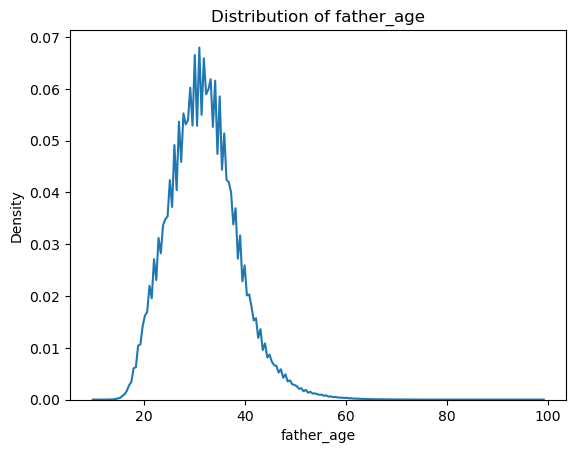

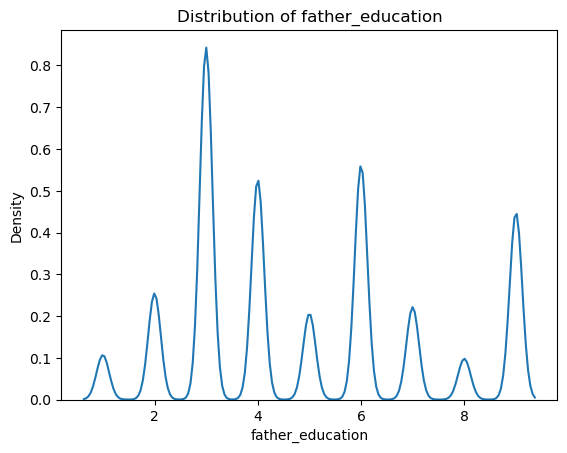

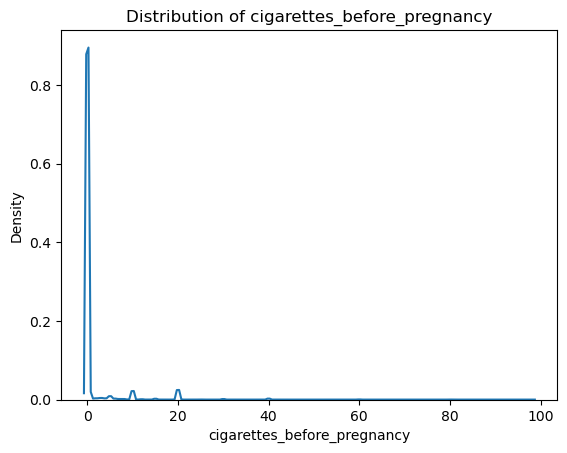

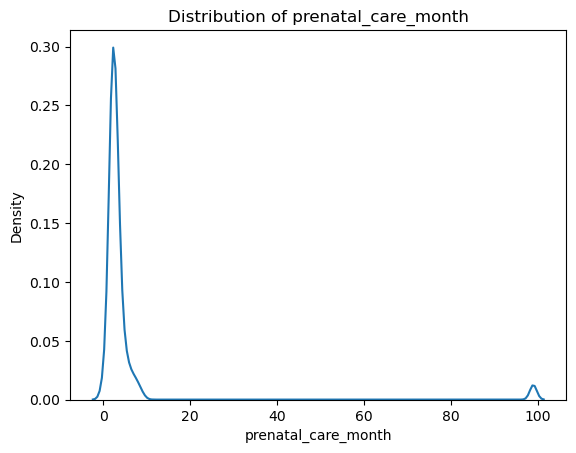

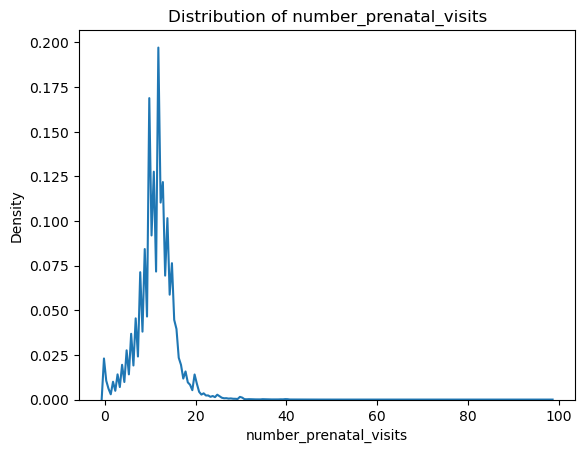

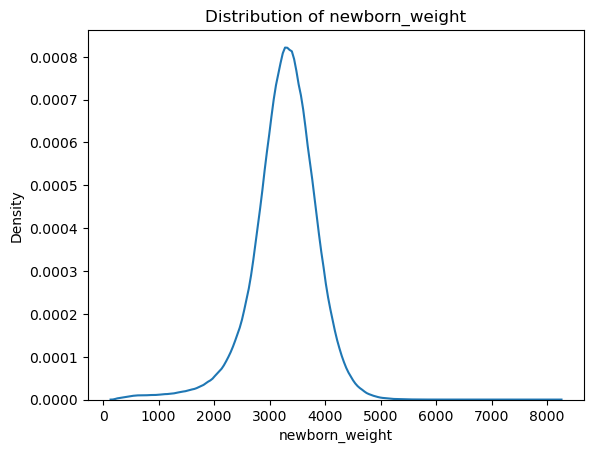

In [4]:

exclude_cols = ['previous_cesarean', 'newborn_gender']

for col in df:
    if col in exclude_cols:
        continue  # skip this column
        
    if df[col].dtype == 'object':
        sns.countplot(x=col, data=df)
    else:
        sns.kdeplot(x=col, data=df)
    plt.xlabel(col)
    plt.title(f"Distribution of {col}")
    plt.show()

## Target is to explain body weight of the new born Child

But first we check for missing values

In [5]:
## Checking colums with missing values

missingValue_train = df.columns[df.isnull().any()].tolist()
print(missingValue_train)
missingValue_test = df1.columns[df1.isnull().any()].tolist()
print(missingValue_train)

display(df.isna().sum())
display(df1.isna().sum())

['mother_body_mass_index', 'mother_marital_status', 'mother_delivery_weight', 'mother_height', 'mother_weight_gain', 'father_age', 'cigarettes_before_pregnancy', 'number_prenatal_visits']
['mother_body_mass_index', 'mother_marital_status', 'mother_delivery_weight', 'mother_height', 'mother_weight_gain', 'father_age', 'cigarettes_before_pregnancy', 'number_prenatal_visits']


mother_body_mass_index         146600
mother_marital_status          412510
mother_delivery_weight          34958
mother_race                         0
mother_height                  244529
mother_weight_gain              73473
father_age                     444506
father_education                    0
cigarettes_before_pregnancy     11301
prenatal_care_month                 0
number_prenatal_visits          59901
previous_cesarean                   0
newborn_gender                      0
newborn_weight                      0
dtype: int64

mother_body_mass_index          36791
mother_marital_status          103384
mother_delivery_weight           8644
mother_race                         0
mother_height                   61559
mother_weight_gain              18334
father_age                     110518
father_education                    0
cigarettes_before_pregnancy      2907
prenatal_care_month                 0
number_prenatal_visits          14985
previous_cesarean                   0
newborn_gender                      0
dtype: int64

Drop columns with a high percentage of missing values (e.g., more than 50%):

In [6]:
#Checking dimension before 
print("Dimensions: ", df.shape)
print("Dimensions: ", df1.shape)

#Dropping columns where there is 50% of NAs
threshold = 0.5  # Set the threshold for dropping columns
df = df.dropna(thresh=len(df) * threshold, axis=1)

df1 = df1.dropna(thresh=len(df1) * threshold, axis=1)

#Checking Dimensions after
print("Dimensions after: ", df.shape)
print("Dimensions after: ", df1.shape)

Dimensions:  (2398116, 14)
Dimensions:  (599561, 13)
Dimensions after:  (2398116, 14)
Dimensions after:  (599561, 13)


None of the columns are dropped

### Now, there are categorical parameters with missing values. It is not feasible with median or Mode imputation. So we go ahead with Most frequent value imputation.

(all values are float/int type)

Checking the distributions in EDA, we proceeded to impute in following way:
**For numerical variables** like mother_body_mass_index, mother_delivery_weight, mother_height, mother_weight_gain, and father_age, number_prenatal_visits,  **median imputation** can be suitable as the missingness is **random and skewed**.

**For categorical variables** like mother_marital_status, cigarettes_before_pregnancy, **mode imputation** can be used to replace missing values with the most **frequent category**. 



**FOR TRAIN DATASETS**

In [7]:
dfCatCol = df[['mother_marital_status', 'cigarettes_before_pregnancy']]
dfNumCol = df[['mother_body_mass_index', 'mother_delivery_weight', 'mother_height', 'mother_weight_gain', 'father_age','number_prenatal_visits']]

#missval_df = df.select_dtypes(include='number').columns.tolist()
dfCatCol_imp = dfCatCol.fillna(dfCatCol.median())
dfNumCol_imp = dfNumCol.fillna(dfNumCol.median()) 

# display(dfNumCol_imp.isna().sum())
# display(dfCatCol_imp.isna().sum())

df = df.assign(
    mother_marital_status=dfCatCol_imp['mother_marital_status'],
#    mother_race=dfCatCol_imp['mother_race'],
#    father_education=dfCatCol_imp['father_education'],
    cigarettes_before_pregnancy=dfCatCol_imp['cigarettes_before_pregnancy'],
#    prenatal_care_month=dfCatCol_imp['prenatal_care_month'],
    mother_body_mass_index=dfNumCol_imp['mother_body_mass_index'],
    mother_delivery_weight=dfNumCol_imp['mother_delivery_weight'],
    mother_height=dfNumCol_imp['mother_height'],
    mother_weight_gain=dfNumCol_imp['mother_weight_gain'],
    father_age=dfNumCol_imp['father_age'],
    number_prenatal_visits=dfNumCol_imp['number_prenatal_visits']
)

#print(df.head)
display(df.isna().sum())
print("Dimensions: ", df.shape)

mother_body_mass_index         0
mother_marital_status          0
mother_delivery_weight         0
mother_race                    0
mother_height                  0
mother_weight_gain             0
father_age                     0
father_education               0
cigarettes_before_pregnancy    0
prenatal_care_month            0
number_prenatal_visits         0
previous_cesarean              0
newborn_gender                 0
newborn_weight                 0
dtype: int64

Dimensions:  (2398116, 14)


**FOR TEST DATASETS**

In [8]:
dfCatCol_test = df1[['mother_marital_status', 'cigarettes_before_pregnancy']]
dfNumCol_test = df1[['mother_body_mass_index', 'mother_delivery_weight', 'mother_height', 'mother_weight_gain', 'father_age','number_prenatal_visits']]

#missval_df = df.select_dtypes(include='number').columns.tolist()
dfCatCol_imp_test = dfCatCol.fillna(dfCatCol_test.median())
dfNumCol_imp_test = dfNumCol.fillna(dfNumCol_test.median()) 

# display(dfNumCol_imp.isna().sum())
# display(dfCatCol_imp.isna().sum())

df1 = df1.assign(
    mother_marital_status=dfCatCol_imp['mother_marital_status'],
#    mother_race=dfCatCol_imp['mother_race'],
#    father_education=dfCatCol_imp['father_education'],
    cigarettes_before_pregnancy=dfCatCol_imp['cigarettes_before_pregnancy'],
#    prenatal_care_month=dfCatCol_imp['prenatal_care_month'],
    mother_body_mass_index=dfNumCol_imp['mother_body_mass_index'],
    mother_delivery_weight=dfNumCol_imp['mother_delivery_weight'],
    mother_height=dfNumCol_imp['mother_height'],
    mother_weight_gain=dfNumCol_imp['mother_weight_gain'],
    father_age=dfNumCol_imp['father_age'],
    number_prenatal_visits=dfNumCol_imp['number_prenatal_visits']
)

#print(df.head)
display(df1.isna().sum())
print("Dimensions: ", df1.shape)

mother_body_mass_index         0
mother_marital_status          0
mother_delivery_weight         0
mother_race                    0
mother_height                  0
mother_weight_gain             0
father_age                     0
father_education               0
cigarettes_before_pregnancy    0
prenatal_care_month            0
number_prenatal_visits         0
previous_cesarean              0
newborn_gender                 0
dtype: int64

Dimensions:  (599561, 13)


**Saving the Data**

In [12]:
#df= pd.get_dummies(df, columns=['previous_cesarean', 'newborn_gender'])
#df1= pd.get_dummies(df1, columns=['previous_cesarean', 'newborn_gender'])

print(df.info())
print(df1.info())
print("Dimensions: ", df1.shape)
print("Dimensions: ", df.shape)

df.to_csv('../data/preprocessed/newborntrain_processed.csv',sep=";")
df1.to_csv('../data/preprocessed/newborntest_processed.csv',sep=";")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2398116 entries, 0 to 2398115
Data columns (total 17 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   mother_body_mass_index       float64
 1   mother_marital_status        float64
 2   mother_delivery_weight       float64
 3   mother_race                  int64  
 4   mother_height                float64
 5   mother_weight_gain           float64
 6   father_age                   float64
 7   father_education             int64  
 8   cigarettes_before_pregnancy  float64
 9   prenatal_care_month          int64  
 10  number_prenatal_visits       float64
 11  newborn_weight               int64  
 12  previous_cesarean_N          uint8  
 13  previous_cesarean_U          uint8  
 14  previous_cesarean_Y          uint8  
 15  newborn_gender_F             uint8  
 16  newborn_gender_M             uint8  
dtypes: float64(8), int64(4), uint8(5)
memory usage: 231.0 MB
None
<class 'pandas.core.fr

# 3. Model Training and Final Testing



In [5]:
# Loading the training data
df = pd.read_csv('../data/preprocessed/newborntrain_processed.csv', sep=";")
#print(df.head())
# Removing the target variable from the feature
X = df.drop("newborn_weight", axis=1)
Y = df["newborn_weight"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=12345)

MLmodel = RandomForestRegressor(n_estimators=200, max_depth=10)
MLmodel.fit(X_train,Y_train)

Y_Pred = MLmodel.predict(X_test)

Mape = mean_absolute_percentage_error(Y_test,Y_Pred)


0.157110394459117


# 4. Data Prediction

In [7]:
df_test = pd.read_csv("../data/preprocessed/newborntest_processed.csv", sep=";")
#print(df_test.info)

pred = MLmodel.predict(df_test)
df_test['predicted_weight'] = pred
print(pred.shape)
print(pred)

df_test.to_csv('RandomForestPred.csv')

(599561,)
[3304.35318089 3326.27637093 3103.3795382  ... 3321.11493172 3510.19309511
 3137.8997528 ]
